In [1]:
# typstifier
# training/main.ipynb

In [2]:
import numpy as np
import jax.numpy as jnp
from flax import nnx
import matplotlib.pyplot as plt
import pickle
import optax
import model as m

np.random.seed(41)

In [3]:
with open("numpydata.pkl", "rb") as f:
    (xs_all, ys_all) = pickle.load(f)

img_size = xs_all.shape[1]
total_img_num = xs_all.shape[0]
total_sym_num = ys_all.shape[1]

def unison_shuffled(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)

def prepare_batch(xs, ys, u, v):
    len_tot = xs.shape[0]
    u_trunc, v_trunc = u % len_tot, v % len_tot

    if u_trunc == 0 and u > 0:
        unison_shuffled(xs, ys)
    
    if v_trunc == u_trunc + (v - u):
        xs_o = xs[u_trunc:v_trunc, ...]
        ys_o = ys[u_trunc:v_trunc, ...]
    else:
        xs_first = xs[u_trunc:, ...]
        ys_first = ys[u_trunc:, ...]
        unison_shuffled(xs, ys)
        xs_second = xs[:v_trunc, ...]
        ys_second = ys[:v_trunc, ...]
        xs_o = np.concatenate([xs_first, xs_second])
        ys_o = np.concatenate([ys_first, ys_second])
       
    return jnp.array(xs_o), jnp.array(ys_o)

unison_shuffled(xs_all, ys_all)
u, v = int(0.8 * total_img_num), int(0.9 * total_img_num)
xs_train, ys_train = xs_all[:u, ...], ys_all[:u, ...]
xs_val, ys_val = xs_all[u:v, ...], ys_all[u:v, ...]
xs_test, ys_test = xs_all[v:, ...], ys_all[v:, ...]

print(f"Image size: {img_size}x{img_size}")
print(f"Dataset sizes: train {u}, val {v - u}, test {total_img_num - v}")
print(f"Number of symbols: {total_sym_num}")
print(f"Cross entropy loss for random selection: {np.log(total_sym_num):.3f}")

Image size: 64x64
Dataset sizes: train 33000, val 4125, test 4125
Number of symbols: 825
Cross entropy loss for random selection: 6.715


In [4]:
model = m.ConvNet(rngs = nnx.Rngs(42))
gradient_transform = optax.chain(
    optax.clip_by_global_norm(1.0),
    optax.adamw(1e-3, weight_decay = 1e-2),
)
optimizer = nnx.Optimizer(model, gradient_transform)
total = 500_000
batch_size = 32

@nnx.jit
def train_step(model, optimizer, x, y):
    loss, grads = nnx.value_and_grad(m.loss_fn)(model, x, y)
    optimizer.update(grads)
    return loss, optax.tree_utils.tree_l2_norm(grads)

@nnx.jit
def eval_step(model, x, y):
    return m.loss_fn(model, x, y)

In [5]:
print_frequency = 50_000
alpha = 0.99

train_losses = []
train_losses_eval = []
val_losses = []
grad_norms = []

model.train() # Use dropout

for i in range(total):
    u, v = i * batch_size, (i + 1) * batch_size
    xs_t, ys_t = prepare_batch(xs_train, ys_train, u, v)
    xs_v, ys_v = prepare_batch(xs_val, ys_val, u, v)

    new_train_loss, new_grad_norm = train_step(model, optimizer, xs_t, ys_t)
    
    model.eval() # Disable dropout in this block
    new_train_loss_eval = eval_step(model, xs_t, ys_t)
    new_val_loss = eval_step(model, xs_v, ys_v)
    model.train()

    if i == 0:
        train_losses.append(new_train_loss)
        train_losses_eval.append(new_train_loss_eval)
        val_losses.append(new_val_loss)
        grad_norms.append(new_grad_norm)
    else:
        train_losses.append(alpha * train_losses[-1] + (1 - alpha) * new_train_loss)
        train_losses_eval.append(alpha * train_losses_eval[-1] + (1 - alpha) * new_train_loss_eval)
        val_losses.append(alpha * val_losses[-1] + (1 - alpha) * new_val_loss)
        grad_norms.append(alpha * grad_norms[-1] + (1 - alpha) * new_grad_norm)
    
    if (i + 1) % print_frequency == 0:
        print(
            f"{(i + 1) * batch_size}: train loss {train_losses[-1]:.3f}, train eval loss {train_losses_eval[-1]:.3f},",
            f"val loss {val_losses[-1]:.3f}, grad norm {grad_norms[-1]:.3f}"
        )

# Save checkpoint
with open(f"checkpoints/modelcheck-{total}.pkl", "wb") as f:
    pickle.dump(nnx.state(model), f)

1600000: train loss 2.497, train eval loss 1.297, val loss 1.623, grad norm 11.107
3200000: train loss 2.167, train eval loss 1.007, val loss 1.295, grad norm 12.391
4800000: train loss 2.029, train eval loss 0.882, val loss 1.191, grad norm 14.223
6400000: train loss 1.922, train eval loss 0.822, val loss 1.138, grad norm 13.463
8000000: train loss 1.892, train eval loss 0.774, val loss 1.090, grad norm 12.967
9600000: train loss 1.875, train eval loss 0.758, val loss 1.070, grad norm 14.179
11200000: train loss 1.811, train eval loss 0.712, val loss 1.042, grad norm 13.567
12800000: train loss 1.776, train eval loss 0.708, val loss 1.030, grad norm 13.575
14400000: train loss 1.779, train eval loss 0.670, val loss 1.008, grad norm 12.850
16000000: train loss 1.791, train eval loss 0.691, val loss 0.989, grad norm 13.467


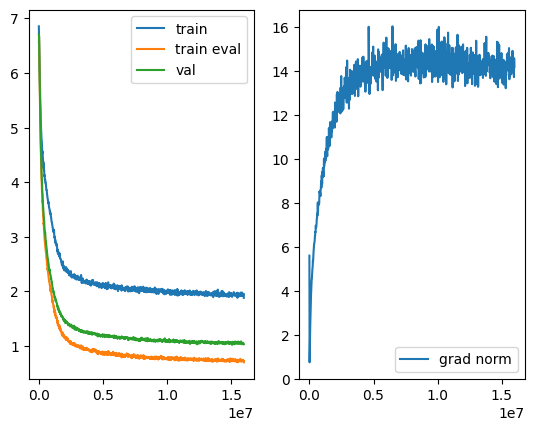

In [6]:
plot_step = 500

%matplotlib inline
fig, (ax_l, ax_r) = plt.subplots(1, 2)
ax_l.plot(batch_size * np.arange(0, total, 500), train_losses[::plot_step], label = "train")
ax_l.plot(batch_size * np.arange(0, total, 500), train_losses_eval[::plot_step], label = "train eval")
ax_l.plot(batch_size * np.arange(0, total, 500), val_losses[::plot_step], label = "val")
ax_r.plot(batch_size * np.arange(0, total, 500), grad_norms[::plot_step], label = "grad norm")
ax_l.legend()
ax_r.legend();

In [7]:
# Report test error

# Load checkpoint (not necessary if training loop was executed)
model = m.ConvNet(rngs = nnx.Rngs(42))
with open(f"checkpoints/modelcheck-{total}.pkl", "rb") as f:
    state = pickle.load(f)
nnx.update(model, state)

loop_num = xs_test.shape[0] // batch_size
test_loss = 0

model.eval() # Disable dropout

for i in range(loop_num):
    u, v = i * batch_size, (i + 1) * batch_size
    xs, ys = prepare_batch(xs_test, ys_test, u, v)
    test_loss += eval_step(model, xs, ys)

test_loss /= loop_num

print(f"Final: test loss {test_loss:.5f}")

Final: test loss 1.04148


In [8]:
# Run example to compare to Rust inference code

x = 1e-4 * np.arange(0, 64 * 64)
x = np.reshape(x, (1, 64, 64, 1))
x = nnx.softmax(model(x))
ordered = list(range(825))
ordered.sort(key = lambda i: x[0, i], reverse = True)        
print(f"Result: {ordered[:10]}")

Result: [35, 9, 127, 374, 379, 760, 771, 392, 49, 198]
